In [1]:
import polars as pl

df_orig = pl.read_csv("Healthcare.csv")
df_orig

Patient_ID,Age,Gender,Symptoms,Symptom_Count,Disease
i64,i64,str,str,i64,str
1,29,"""Male""","""fever, back pain, shortness of…",3,"""Allergy"""
2,76,"""Female""","""insomnia, back pain, weight lo…",3,"""Thyroid Disorder"""
3,78,"""Male""","""sore throat, vomiting, diarrhe…",3,"""Influenza"""
4,58,"""Other""","""blurred vision, depression, we…",4,"""Stroke"""
5,55,"""Female""","""swelling, appetite loss, nause…",3,"""Heart Disease"""
…,…,…,…,…,…
24996,42,"""Male""","""runny nose, muscle pain, anxie…",6,"""Ulcer"""
24997,36,"""Male""","""fever, blurred vision, insomni…",6,"""Common Cold"""
24998,70,"""Other""","""anxiety, nausea, tremors""",3,"""Anxiety"""


In [2]:
df_orig=df_orig.drop(["Patient_ID"])

In [3]:
for c in df_orig.columns:
    print(df_orig[c].value_counts())

shape: (90, 2)
┌─────┬───────┐
│ Age ┆ count │
│ --- ┆ ---   │
│ i64 ┆ u32   │
╞═════╪═══════╡
│ 57  ┆ 272   │
│ 84  ┆ 282   │
│ 48  ┆ 282   │
│ 31  ┆ 266   │
│ 83  ┆ 275   │
│ …   ┆ …     │
│ 12  ┆ 268   │
│ 68  ┆ 266   │
│ 46  ┆ 263   │
│ 22  ┆ 295   │
│ 62  ┆ 276   │
└─────┴───────┘
shape: (3, 2)
┌────────┬───────┐
│ Gender ┆ count │
│ ---    ┆ ---   │
│ str    ┆ u32   │
╞════════╪═══════╡
│ Female ┆ 8336  │
│ Other  ┆ 8393  │
│ Male   ┆ 8271  │
└────────┴───────┘
shape: (24_359, 2)
┌─────────────────────────────────┬───────┐
│ Symptoms                        ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ fatigue, weight loss, vomiting… ┆ 1     │
│ swelling, abdominal pain, depr… ┆ 1     │
│ anxiety, sneezing, fatigue, tr… ┆ 1     │
│ sweating, insomnia, vomiting, … ┆ 1     │
│ sneezing, runny nose, nausea, … ┆ 1     │
│ …                               ┆ …     │
│ anxiety, headache, diar

In [4]:
disease_col = df_orig["Disease"]

In [5]:
df = df_orig.with_columns(
    pl.col('Symptoms').str.split(", ")
)

# Step 2: Get all unique symptoms
all_symptoms = (
    df.explode("Symptoms")
    .select(pl.col("Symptoms").unique())
    .to_series()
    .to_list()
)

# Clean up whitespace just in case (optional but safe)
all_symptoms = [s.strip() for s in all_symptoms]

# Step 3: For each symptom, create a binary column
symptom_exprs = [
    pl.when(pl.col("Symptoms").list.contains(symptom))
      .then(1)
      .otherwise(0)
      .alias(f"Symptom_{symptom.replace(' ', '_')}")
    for symptom in all_symptoms
]

# Step 4: Add all one-hot columns
result = df.select(symptom_exprs)
df=df.drop(['Symptoms'])

print(result)

shape: (25_000, 28)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Symptom_a ┆ Symptom_d ┆ Symptom_d ┆ Symptom_a ┆ … ┆ Symptom_c ┆ Symptom_w ┆ Symptom_j ┆ Symptom_ │
│ bdominal_ ┆ iarrhea   ┆ izziness  ┆ nxiety    ┆   ┆ hest_pain ┆ eight_gai ┆ oint_pain ┆ blurred_ │
│ pain      ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ n         ┆ ---       ┆ vision   │
│ ---       ┆ i32       ┆ i32       ┆ i32       ┆   ┆ i32       ┆ ---       ┆ i32       ┆ ---      │
│ i32       ┆           ┆           ┆           ┆   ┆           ┆ i32       ┆           ┆ i32      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0         ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0        │
│ 0         ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0        │
│ 0         ┆ 1         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0    

In [6]:
# df = df.drop(["Symptom"])
df = pl.concat([df,result],how="horizontal")

In [7]:
df = df.with_columns(pl.col("Gender").cast(pl.Categorical).to_physical())

In [8]:
# These are diseases that i work with
allowed_diseases = ['Allergy','Stroke','Influenza','Heart Disease']
allowed_diseases_id = [0,1,2,3]

diseases_mapping = {a:b for a,b in zip(allowed_diseases,allowed_diseases_id)}
diseases_mapping_inv = {a:b for a,b in zip(allowed_diseases_id,allowed_diseases)}


In [9]:
print("Before filtering",len(df))
df = df.filter(df['Disease'].is_in(allowed_diseases))
df = df.with_columns(
    pl.col("Disease").map_elements(lambda x: diseases_mapping[x], return_dtype=pl.Int64).alias("Disease_id")
)
print("After filtering",len(df))
df

Before filtering 25000
After filtering 3276


/tmp/ipykernel_1820903/2394596123.py:4: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("Disease").map_elements(lambda x: ...)
with this one instead:
  + pl.col("Disease").replace_strict(diseases_mapping)

  pl.col("Disease").map_elements(lambda x: diseases_mapping[x], return_dtype=pl.Int64).alias("Disease_id")


Age,Gender,Symptom_Count,Disease,Symptom_abdominal_pain,Symptom_diarrhea,Symptom_dizziness,Symptom_anxiety,Symptom_sore_throat,Symptom_cough,Symptom_runny_nose,Symptom_shortness_of_breath,Symptom_headache,Symptom_insomnia,Symptom_appetite_loss,Symptom_fatigue,Symptom_nausea,Symptom_back_pain,Symptom_vomiting,Symptom_muscle_pain,Symptom_rash,Symptom_sweating,Symptom_swelling,Symptom_sneezing,Symptom_weight_loss,Symptom_fever,Symptom_depression,Symptom_tremors,Symptom_chest_pain,Symptom_weight_gain,Symptom_joint_pain,Symptom_blurred_vision,Disease_id
i64,u32,i64,str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i64
29,0,3,"""Allergy""",0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
78,0,3,"""Influenza""",0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2
58,2,4,"""Stroke""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,1
55,1,3,"""Heart Disease""",0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3
49,0,4,"""Heart Disease""",0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,3
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
41,0,7,"""Influenza""",0,0,0,0,1,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,2
62,2,5,"""Heart Disease""",0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,3
79,1,6,"""Stroke""",0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [10]:
import pandas as pd
# df_orig.describe()
pd.DataFrame(df_orig,columns=df_orig.columns).describe(include="all")

,Age,Gender,Symptoms,Symptom_Count,Disease
count,25000,25000,25000,25000,25000
unique,90,3,24359,5,30
top,40,Other,"sweating, abdominal pain, shortness of breath",3,Anxiety
freq,322,8393,4,5026,911


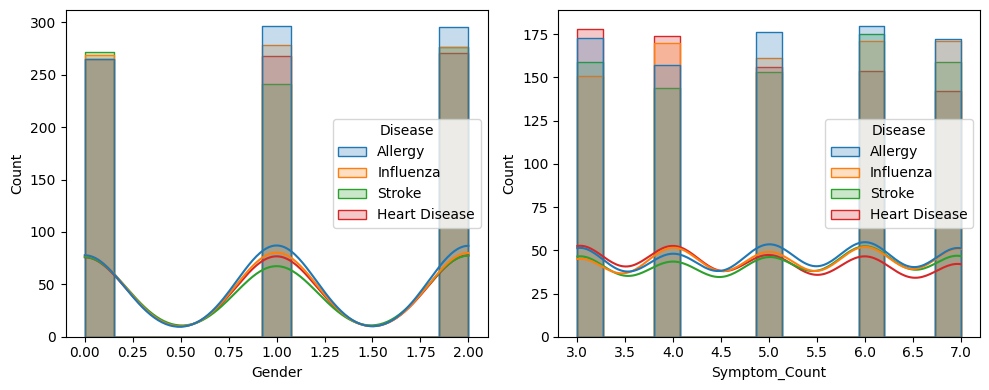

In [11]:
# Диаграммы распределения длины и ширины лепестка по классам
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(
    data=df,
    x="Gender",
    hue="Disease",
    kde=True,
    element="step"
)

plt.subplot(1, 2, 2)
sns.histplot(
    data=df,
    x="Symptom_Count",
    hue="Disease",
    kde=True, # kernel density estimation
    element="step"
)
plt.tight_layout()
plt.show()

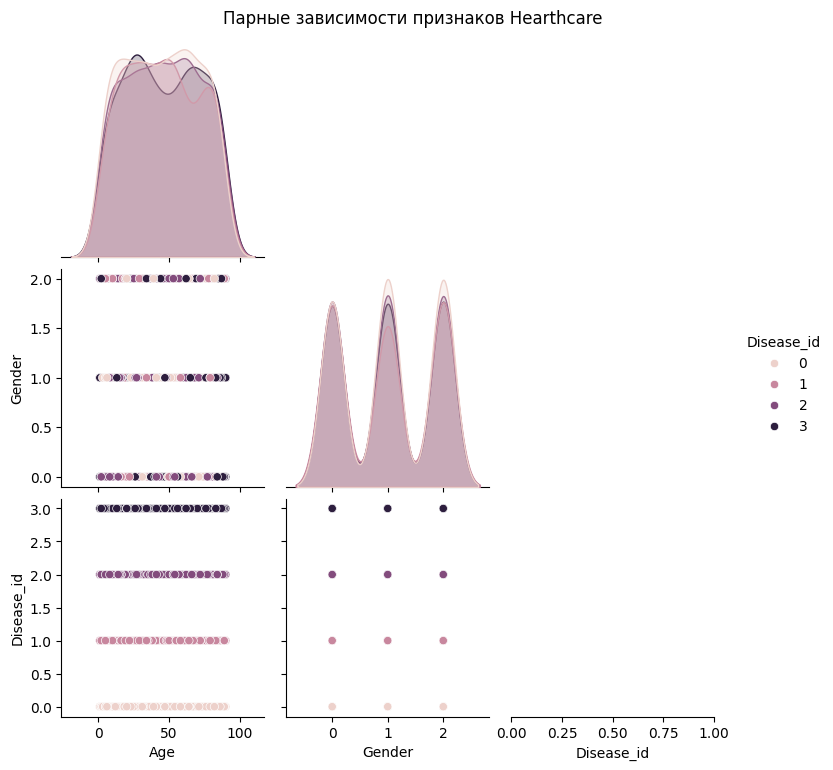

In [12]:
import pandas as pd

df_slice_pd = pd.DataFrame(df,columns=df.columns).drop(columns=['Disease'])
# Парные диаграммы признаков
sns.pairplot(
    df_slice_pd,
    vars=[c for c in df_slice_pd.columns if "Sym" not in c],
    hue="Disease_id",
    corner=True
)
plt.suptitle("Парные зависимости признаков Hearthcare", y=1.02)
plt.show()

In [13]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import RobustScaler

df_numerical = df.drop("Disease")
# scaler = StandardScaler(with_mean=False,with_std=True)
# df_numerical = scaler.fit_transform(df_numerical)

In [14]:
import umap

reducer = umap.UMAP(random_state=42,n_neighbors=20,min_dist=0.2,metric='cosine')  # UMAP как общий алгоритм понижения размерности.
embedding = reducer.fit_transform(df_numerical)  # проекция в 2D‑пространство. 

umap_df = pd.DataFrame(
    embedding,
    columns=["UMAP1", "UMAP2"]
)

/home/vlad/Programs/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


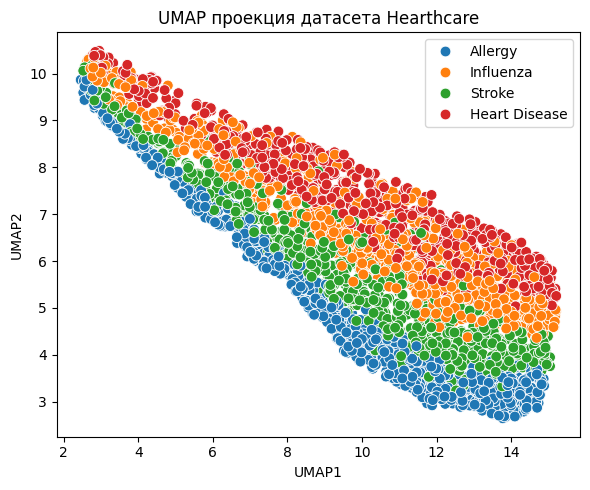

In [15]:
umap_df["Disease"] = disease_col.filter(disease_col.is_in(allowed_diseases))

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=umap_df,
    x="UMAP1",
    y="UMAP2",
    hue="Disease",
    s=60
)
plt.title("UMAP проекция датасета Hearthcare")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
from multidim_visualization import HighDimVisualizer

visualization = HighDimVisualizer(diseases_mapping_inv)
X,Y=df.drop(['Disease']),df['Disease_id']


2. Тепловая карта корреляций


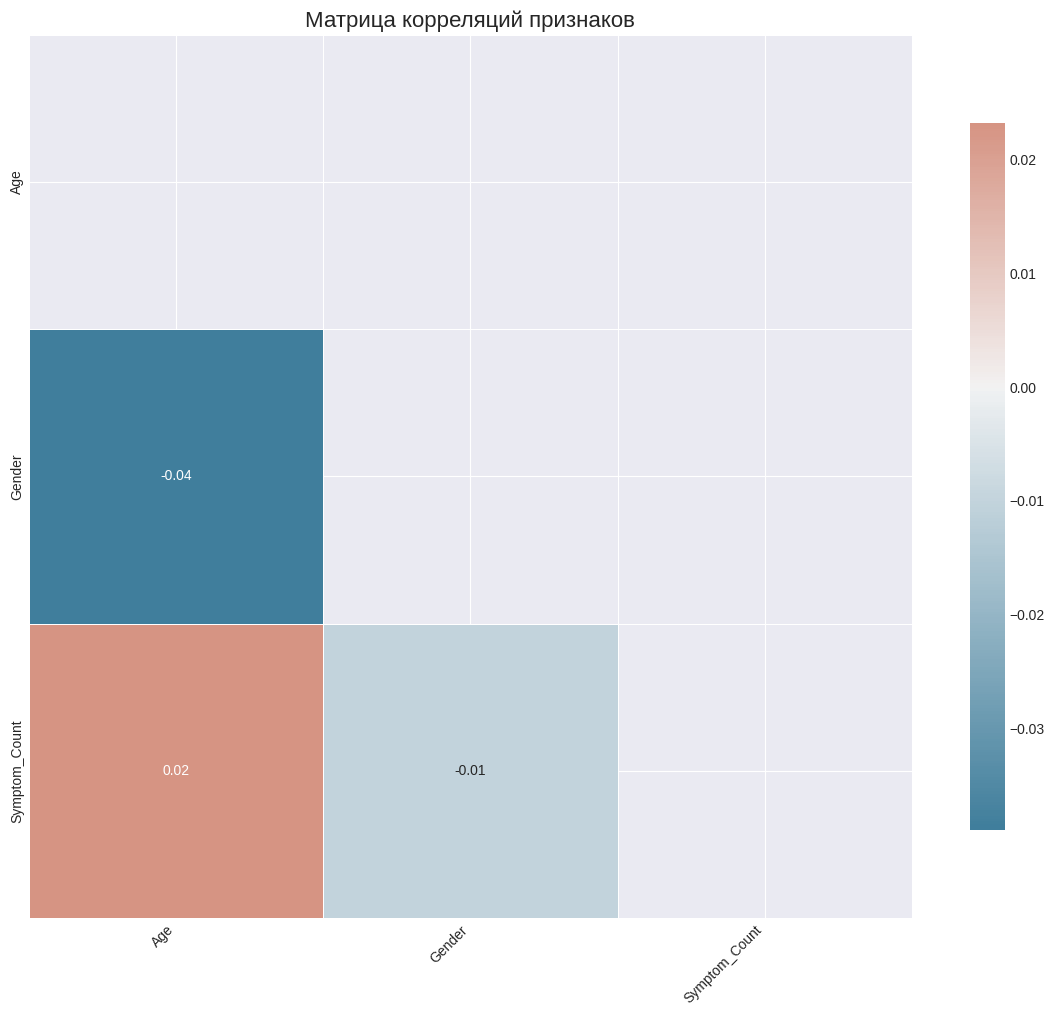

In [17]:
visualization.plot_correlation_heatmap(df['Age',"Gender","Symptom_Count"],['Age',"Gender","Symptom_Count"])

In [18]:
from sklearn.discriminant_analysis import StandardScaler

scaler = StandardScaler()

X_norm = scaler.fit_transform(X)


3. Визуализация PCA (2D и 3D)
Объясненная дисперсия: [0.04719324 0.03704411 0.03658347]
Суммарная объясненная дисперсия: 0.121


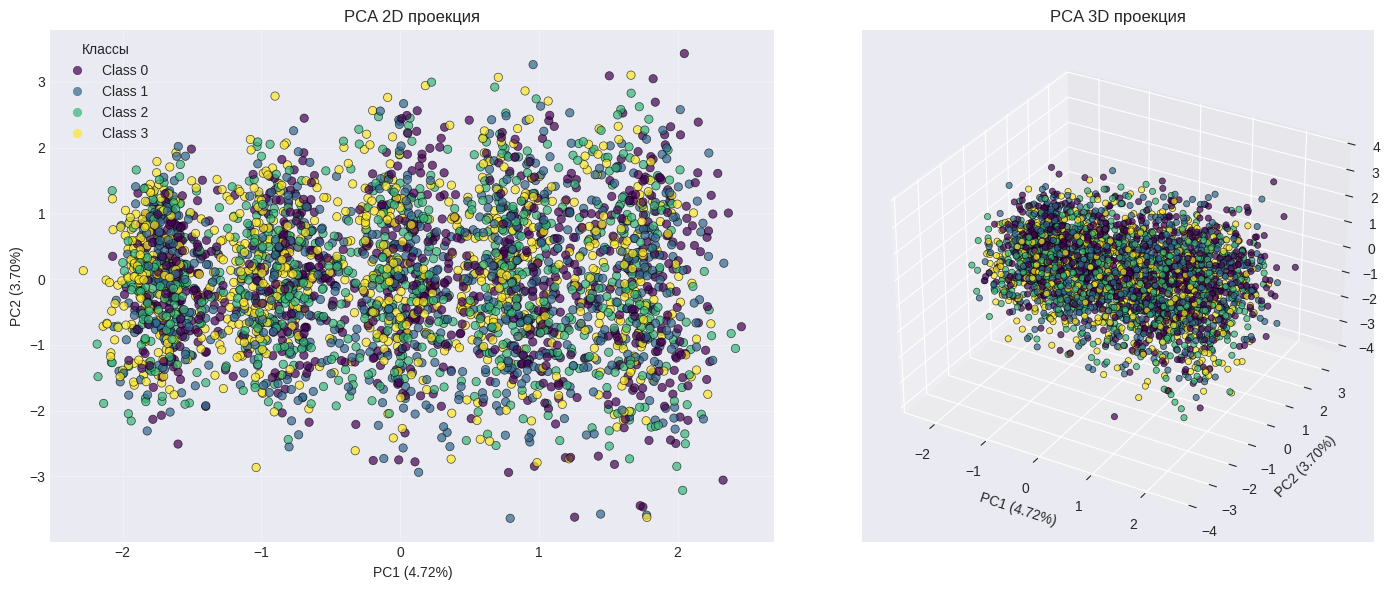

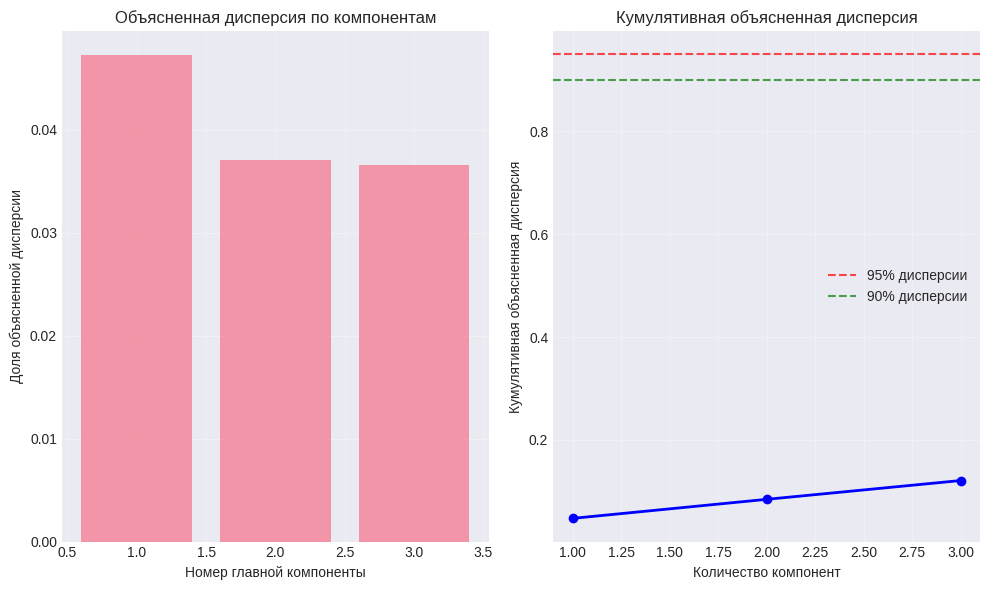

In [19]:
visualization.plot_pca_2d_3d(X_norm,Y)


4. Визуализация t-SNE


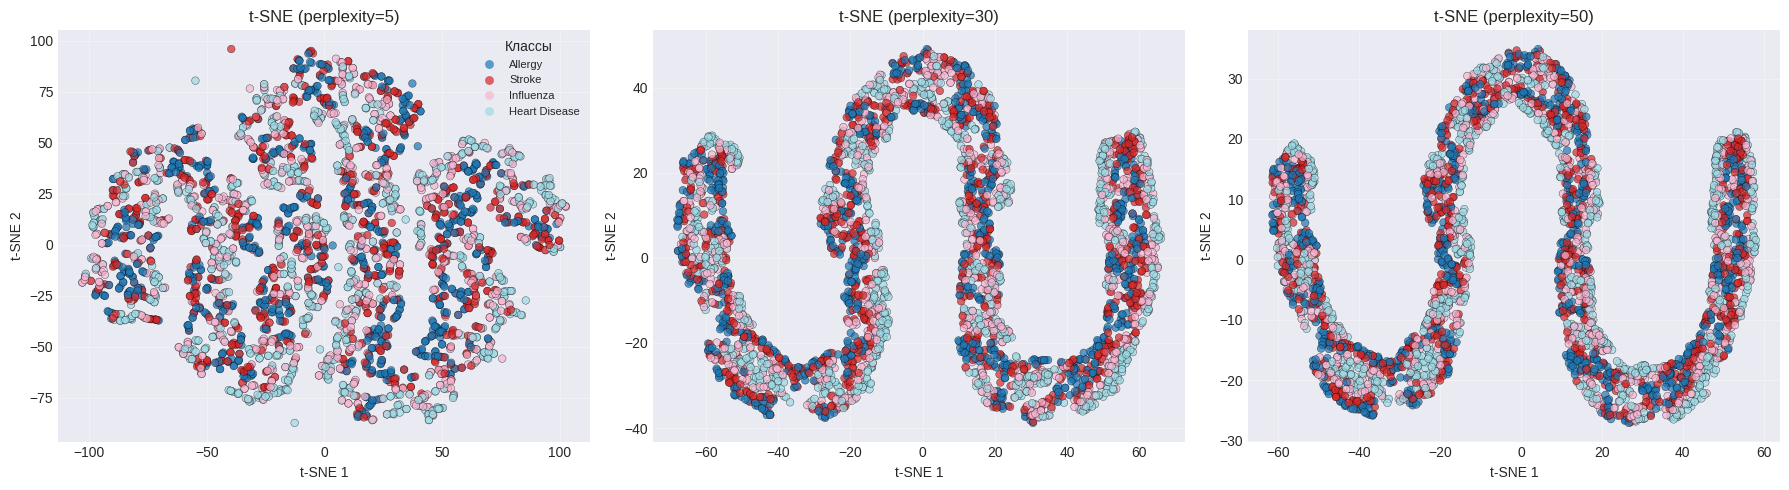

In [20]:
visualization.plot_tsne_visualization(X,Y)

In [ ]:
visualization.plot_umap_visualization(X,Y)


6. Параллельные координаты


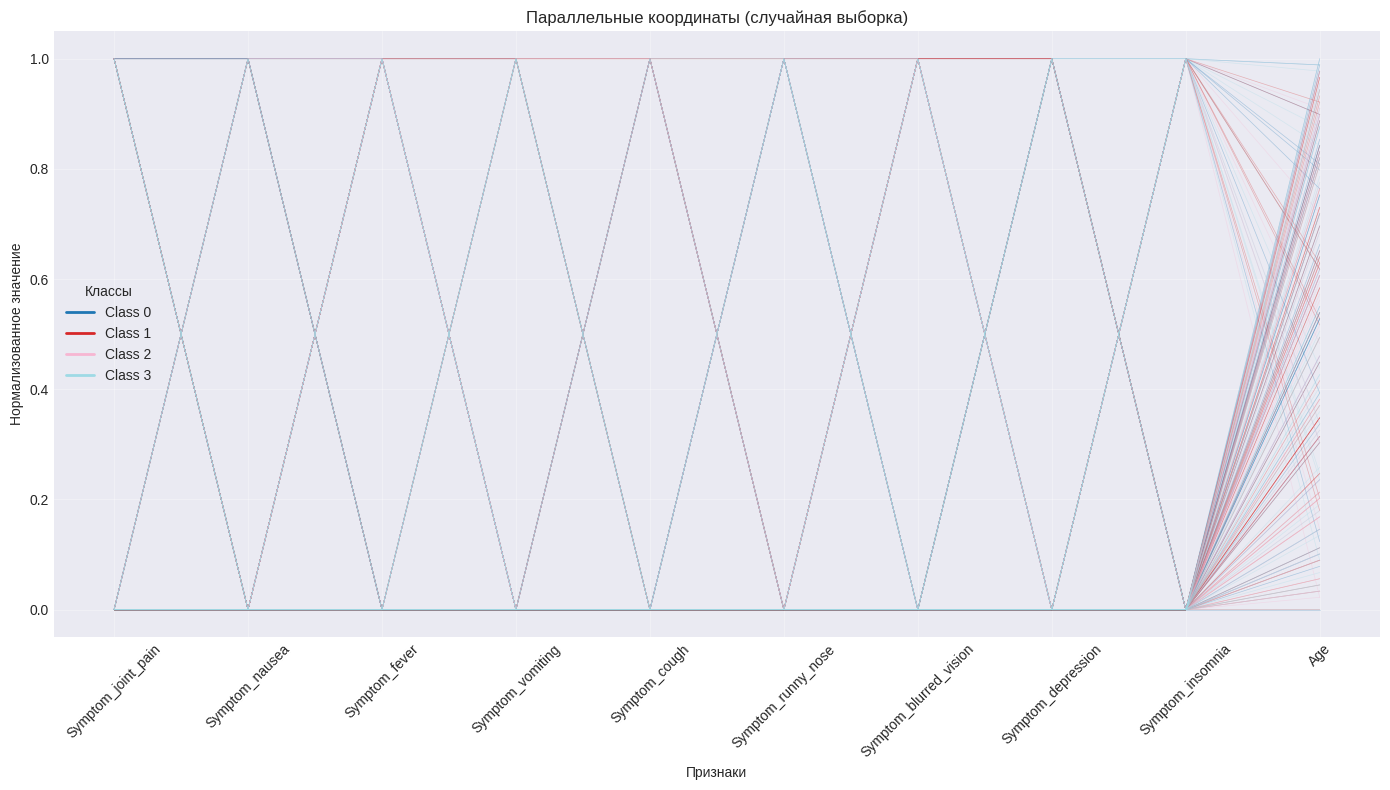

In [22]:
umap_df_num = umap_df[umap_df.columns[:2]].to_numpy()
visualization.plot_parallel_coordinates(X_norm,Y,X.columns)


7. Радар-чарты по классам


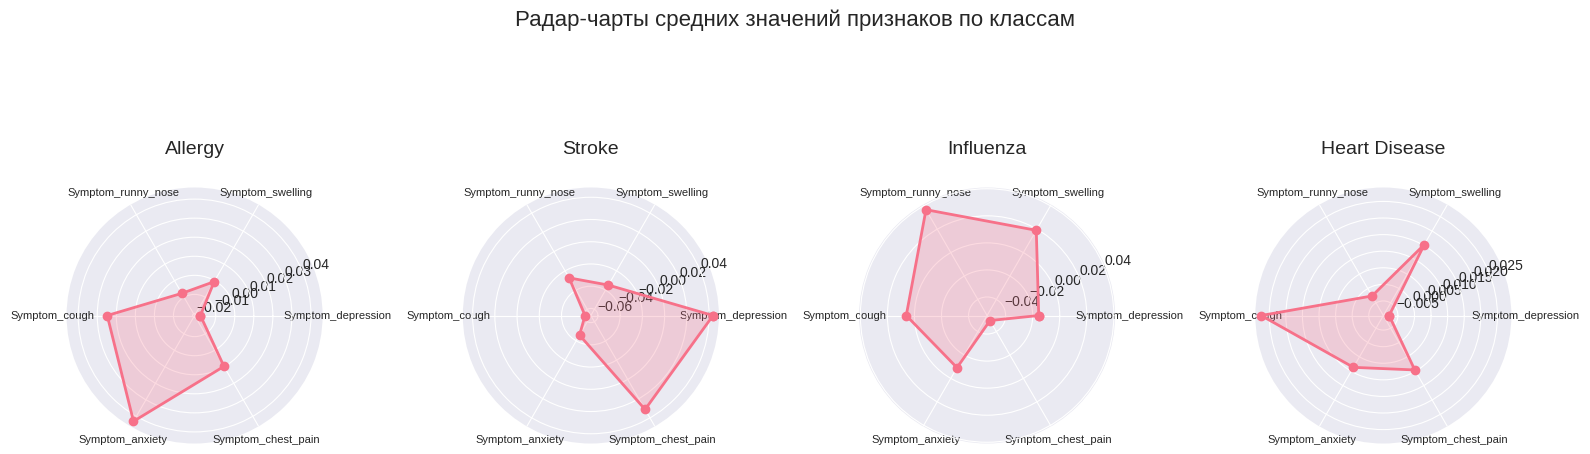

In [23]:
visualization.plot_radar_chart(X_norm,Y,X.columns)

In [24]:
umap3d = umap.UMAP(n_neighbors=30,n_components=3,metric='cosine',min_dist=0.1)
X_3d = umap3d.fit_transform(X)

In [25]:
visualization.plot_interactive_3d(X_3d,Y,["UMAP1","UMAP2","UMAP3"])


8. Интерактивная 3D визуализация (откроется в браузере)
  График сохранен в файл: interactive_3d_plot.html



9. Сравнение методов уменьшения размерности
  Применяем PCA...
  Применяем t-SNE...
  Применяем Isomap...
  Применяем UMAP...


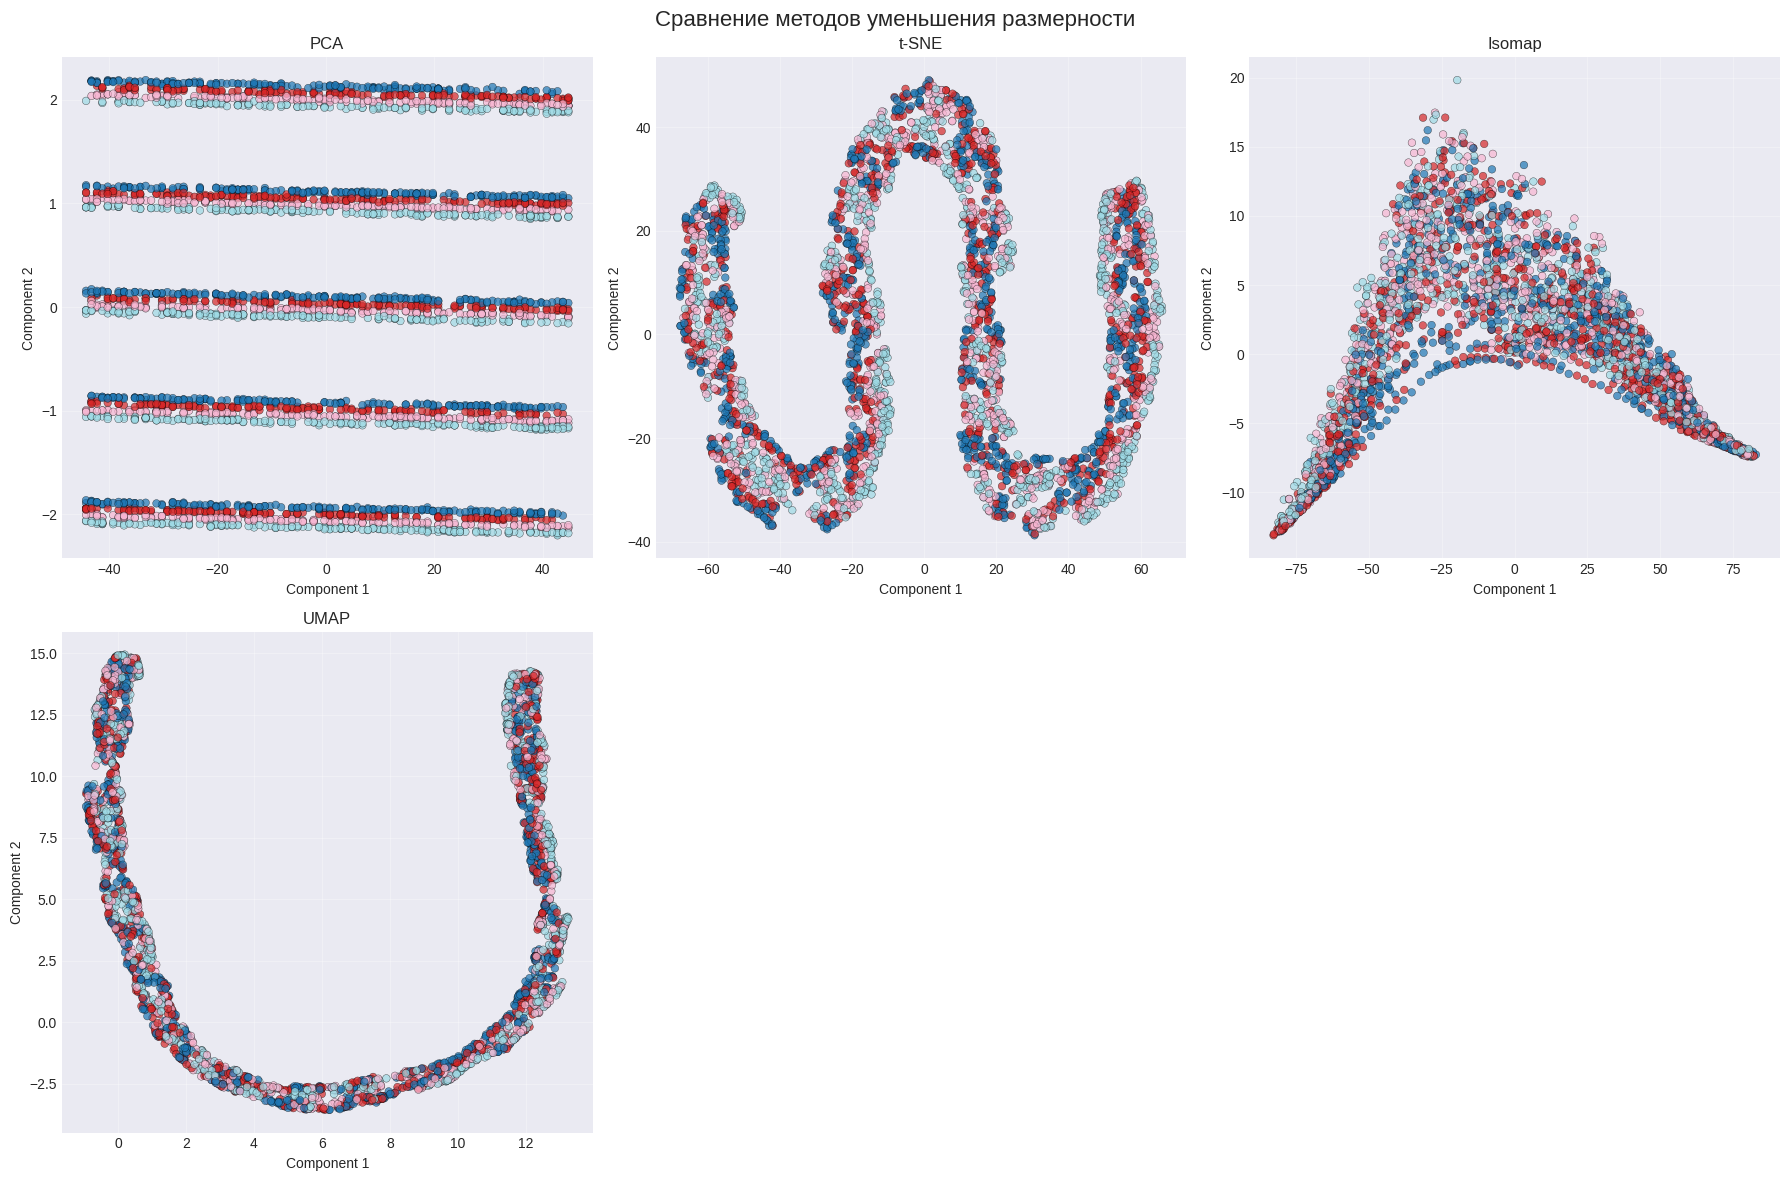

In [26]:
visualization.compare_dim_reduction_methods(X,Y)